In [1]:
import pandas as pd
import numpy as np
import os
import re
import random
from copy import deepcopy 
from sklearn.metrics import f1_score

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from aggregate_metrics_helper import *

In [3]:
os.chdir('/shared/0/projects/research-jam-summer-2024/')
pd.options.mode.copy_on_write = True

In [4]:
all_metrics = {'word_count': 'scalar',
               'perplexity': 'scalar',
               'pos': 'distribution',
               'dep_dpth': 'scalar',
               'dep_brth': 'scalar',
               'dep_dep_dist': 'scalar',
               'sbert': 'vector',
               'punctuation': 'distribution',
               'toxicity': 'scalar',
               'sentiment': 'scalar',
              }
metric_category = {'word_count': 'lexical',
                   'perplexity': 'lexical',
                   'pos': 'syntactic',
                   'dep_dpth': 'syntactic',
                   'dep_brth': 'syntactic',
                   'dep_dep_dist': 'syntactic',
                   'sbert': 'semantic',
                   'punctuation': 'style',
                   'toxicity': 'style',
                   'sentiment': 'style',
                  }

all_cols = ['human_'+k for k in all_metrics] + ['llm_'+k for k in all_metrics]

# Fetch and Harmonize Data

In [5]:
def make_base_dir(language):
    if language == 'english':
        return 'data/english_only/100k_results/with_metrics/'
    else:
        return 'data/'+language+'_only/with_metrics/' #experiment 3

def read_ml_file(f, language):
    print(f)
    base_dir = make_base_dir(language)
    df1 = pd.read_json(base_dir+f, orient='records', lines=True)
    df1.columns = [re.sub('turn_3_|log_|_embedding','',x) for x in df1.columns]
    df1['model'] = re.sub('.*100k_|.*10k_|.jsonl','',f)
    if language!='english':
        df2 = pd.read_json(base_dir+'extra_metrics/'+re.sub('.jsonl','_metrics_pos.jsonl',re.sub('_metrics','',f)),
                           orient='records', lines=True)
    else:
        df1 = df1.drop(['human_pos','llm_pos'], axis=1)
        df2 = pd.read_json(base_dir+'extra_metrics/'+re.sub('.jsonl','_metrics_sbert.jsonl',re.sub('_100k_','_10k_downsampled_',f)),
                           orient='records', lines=True)
        df2.columns = [re.sub('turn_3_|log_|_embedding','',x) for x in df2.columns]
        df3 = pd.read_json(base_dir+re.sub('.jsonl','_POS_DEP.jsonl',f),
                           orient='records', lines=True)
        df2 = df2.merge(df3[[c for c in df3 if c in merge_keys + all_cols]], on = merge_keys, how = 'inner')
    df2['model'] = re.sub('.*100k_|.*10k_|.jsonl','',f)
    merge_df = df1[[c for c in df1 if c in merge_keys + all_cols]].\
                merge(df2[[c for c in df2 if c in merge_keys + all_cols]], on = merge_keys, how = 'inner')
    merge_df['language'] = language
    return merge_df

In [6]:
for language in ['english','chinese','russian']:
    for f in os.listdir(make_base_dir(language)):
        if (f.endswith('-Instruct.jsonl') or f.endswith('B.jsonl') or f.endswith('_metrics.jsonl')) and f.endswith('.jsonl'): 
            print(f)

wildchat_subset_en_100k_Mistral-Large-Instruct.jsonl
wildchat_subset_en_100k_Mixtral-8x7B.jsonl
wildchat_subset_en_100k_Llama-3.1-70B.jsonl
wildchat_subset_cn_10k_Mixtral-8x7B-Instruct_metrics.jsonl
wildchat_subset_cn_10k_Mistral-Large-Instruct_metrics.jsonl
wildchat_subset_cn_10k_Llama-3.1-70B-Instruct_metrics.jsonl
wildchat_subset_ru_10k_Mixtral-8x7B-Instruct.jsonl
wildchat_subset_ru_10k_Llama-3.1-70B-Instruct.jsonl
wildchat_subset_ru_10k_Mistral-Large-Instruct.jsonl


In [7]:
metrics = pd.concat([read_ml_file(f, language) 
                     for language in ['english','chinese','russian']
                     for f in os.listdir(make_base_dir(language))
                     if (f.endswith('-Instruct.jsonl') or f.endswith('B.jsonl') or 
                         f.endswith('_metrics.jsonl')) and f.endswith('.jsonl')]).reset_index(drop=True)

metrics.model = metrics.model.apply(lambda x: re.sub('-Instruct$|-Instruct_metrics$','',x))

wildchat_subset_en_100k_Mistral-Large-Instruct.jsonl
wildchat_subset_en_100k_Mixtral-8x7B.jsonl
wildchat_subset_en_100k_Llama-3.1-70B.jsonl
wildchat_subset_cn_10k_Mixtral-8x7B-Instruct_metrics.jsonl
wildchat_subset_cn_10k_Mistral-Large-Instruct_metrics.jsonl
wildchat_subset_cn_10k_Llama-3.1-70B-Instruct_metrics.jsonl
wildchat_subset_ru_10k_Mixtral-8x7B-Instruct.jsonl
wildchat_subset_ru_10k_Llama-3.1-70B-Instruct.jsonl
wildchat_subset_ru_10k_Mistral-Large-Instruct.jsonl


In [187]:
for k in ['perplexity','dep_dpth', 'dep_brth', 'dep_dep_dist']:
    if 'human_'+k in metrics.columns:
        metrics['human_'+k] = np.log(metrics['human_'+k]+1)
        metrics['llm_'+k] = np.log(metrics['llm_'+k]+1)


In [188]:
metrics.to_csv('data/agg_metrics/multilingual_metrics.csv', index=None)

In [189]:
metrics.columns

Index(['hashed_ip', 'model', 'conversation_hash', 'prompt', 'human_word_count',
       'human_perplexity', 'human_punctuation', 'human_sentiment',
       'human_toxicity', 'llm_word_count', 'llm_perplexity', 'llm_punctuation',
       'llm_sentiment', 'llm_toxicity', 'human_sbert', 'llm_sbert',
       'human_pos', 'llm_pos', 'human_dep_dpth', 'human_dep_brth',
       'human_dep_dep_dist', 'llm_dep_dpth', 'llm_dep_brth',
       'llm_dep_dep_dist', 'language'],
      dtype='object')

In [190]:
pd.crosstab(metrics.language, metrics.model)

model,Llama-3.1-70B,Mistral-Large,Mixtral-8x7B
language,,,
chinese,15050,16379,15888
english,10166,9977,10215
russian,12342,13426,12994


In [111]:
all_lang_end = []
for language in ['english','chinese','russian']:
    for f in os.listdir(make_base_dir(language)):
        if f.endswith('end.jsonl'):
            print(f)
            df = pd.read_json(make_base_dir(language) + f, orient='records', lines=True)
            df['language'] = language
            df['model'] = re.sub('.*100k_|.*10k_|_end.*','',f)
            all_lang_end.append(df)
all_lang_end = pd.concat(all_lang_end)

wildchat_subset_en_100k_Mixtral-8x7B_end.jsonl
wildchat_subset_en_100k_Mistral-Large-Instruct_end.jsonl
wildchat_subset_en_100k_Llama-3.1-70B_end.jsonl
wildchat_subset_cn_10k_Mixtral-8x7B-Instruct_metrics_end.jsonl
wildchat_subset_cn_10k_Llama-3.1-70B-Instruct_metrics_end.jsonl
wildchat_subset_cn_10k_Mistral-Large-Instruct_metrics_end.jsonl
wildchat_subset_ru_10k_Mixtral-8x7B-Instruct_end.jsonl
wildchat_subset_ru_10k_Llama-3.1-70B-Instruct_end.jsonl
wildchat_subset_ru_10k_Mistral-Large-Instruct_end.jsonl


In [221]:
all_lang_end.model = all_lang_end.model.apply(lambda x: re.sub('_metrics|-Instruct','',x))

In [182]:
for lang in ['english','chinese','russian']:
    print(lang,
          np.mean(all_lang_end.human_end[all_lang_end.language==lang]),
          np.mean(all_lang_end.llm_end[all_lang_end.language==lang]))

english 0.64384 0.07576
chinese 0.4487 0.05435555555555555
russian 0.541 0.07243333333333334


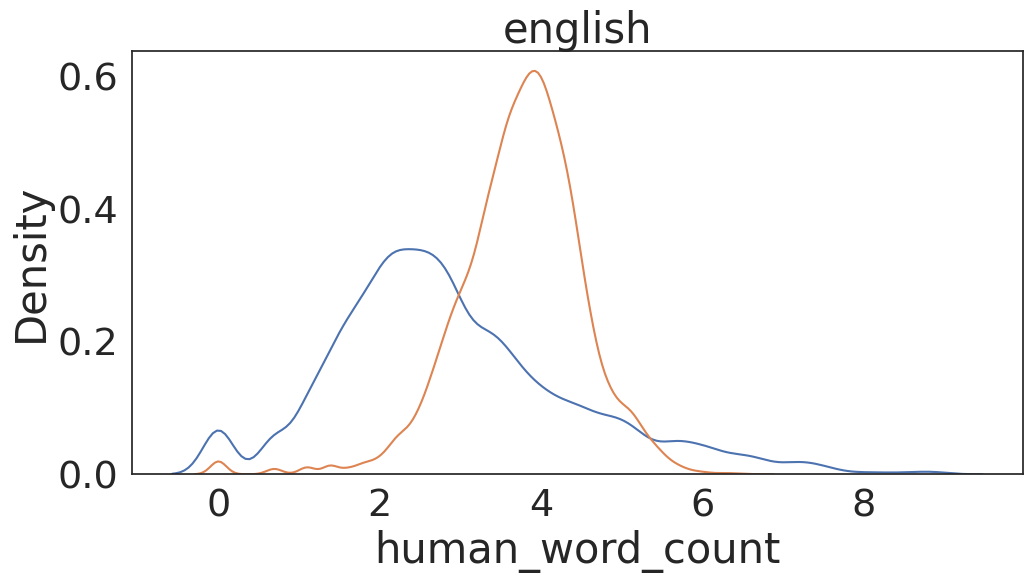

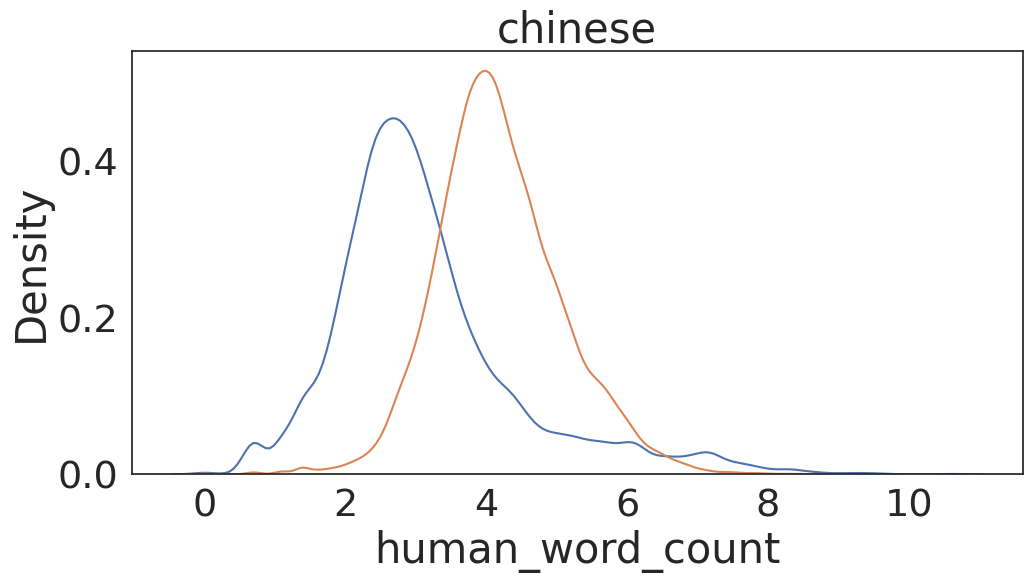

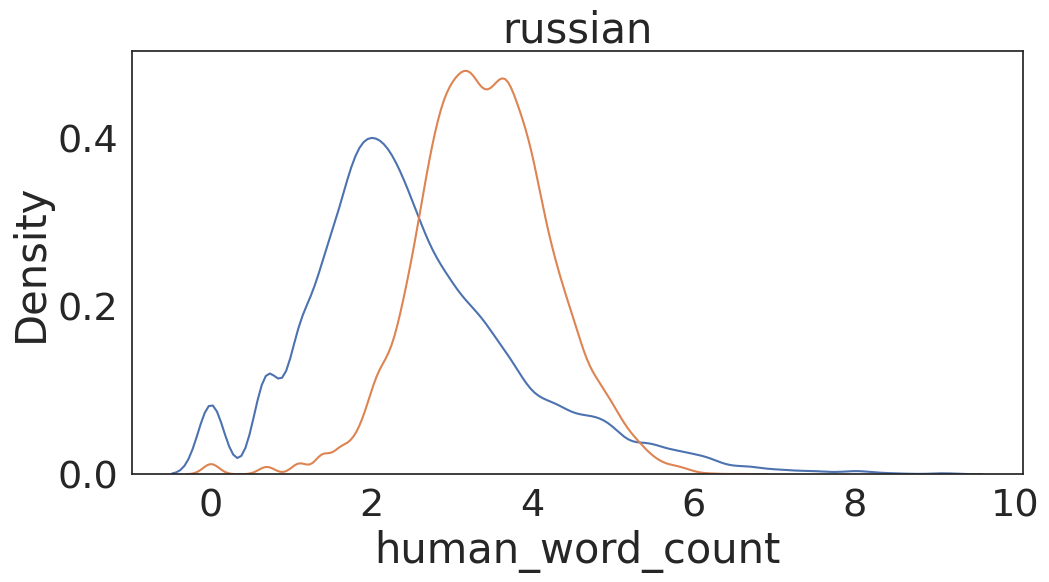

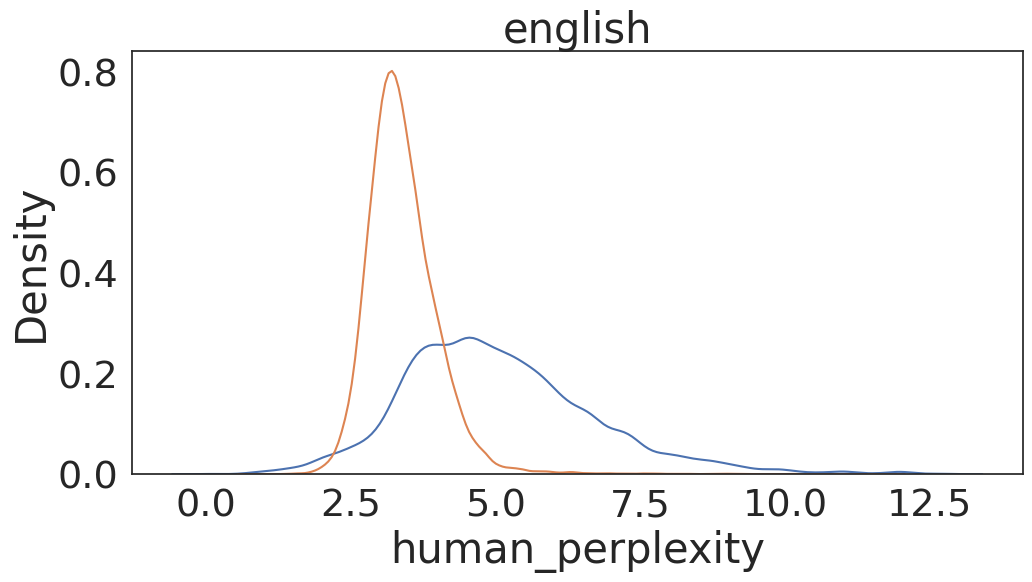

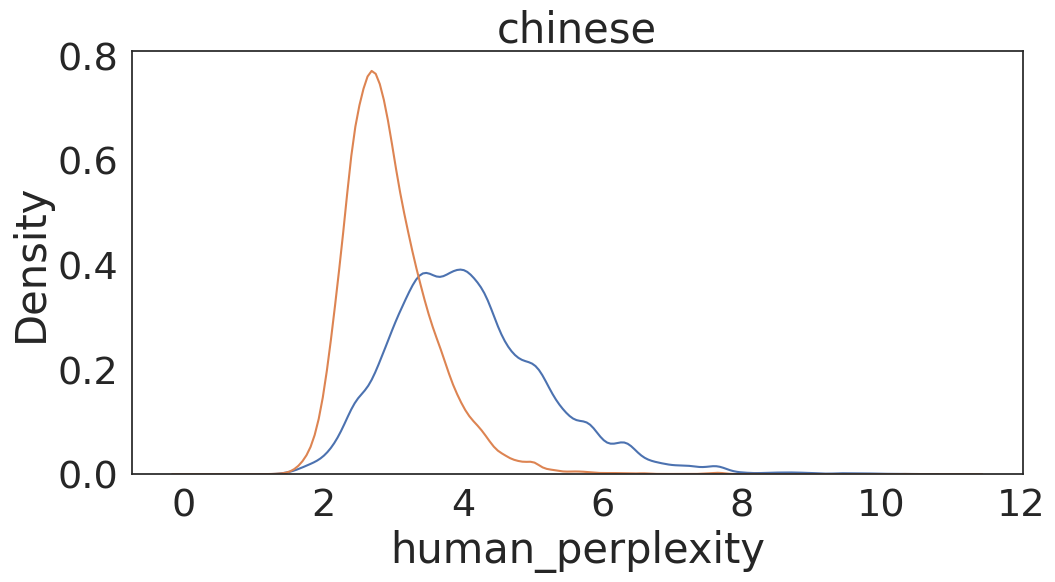

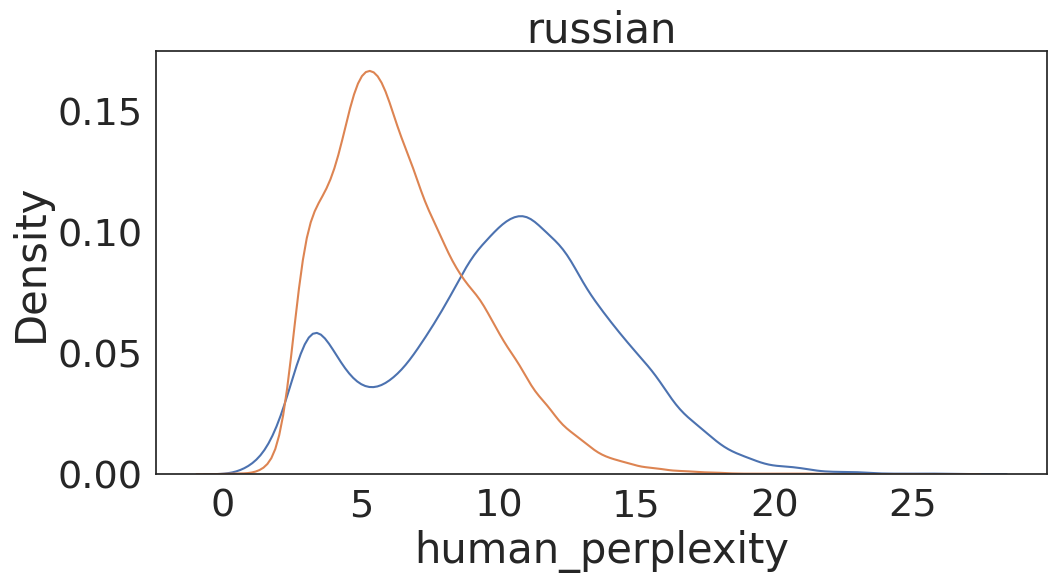

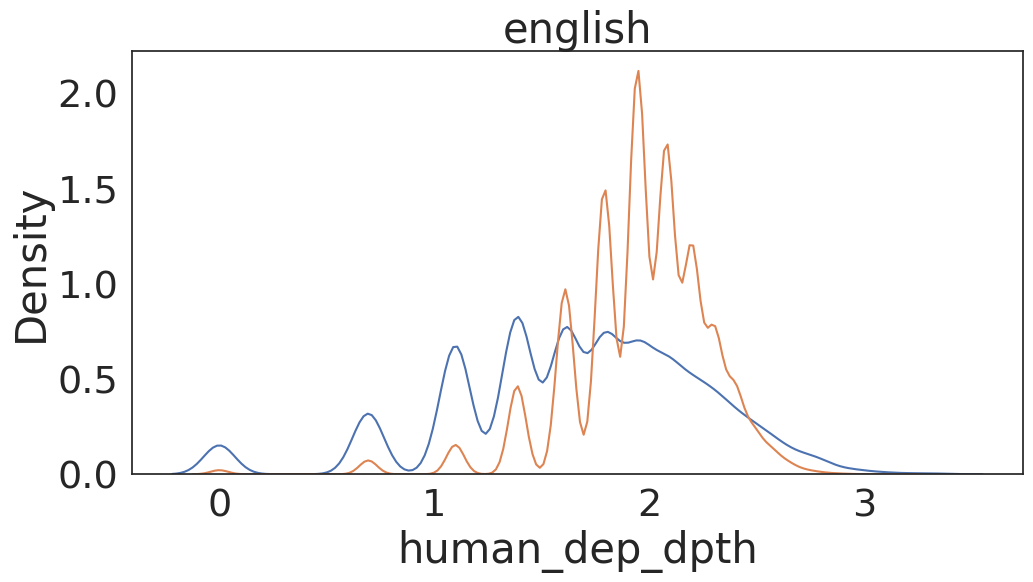

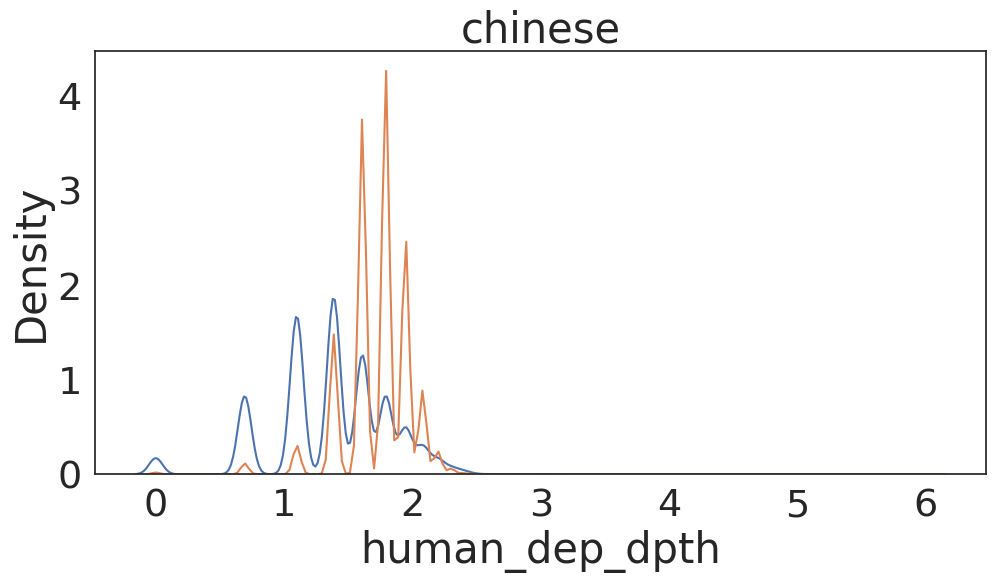

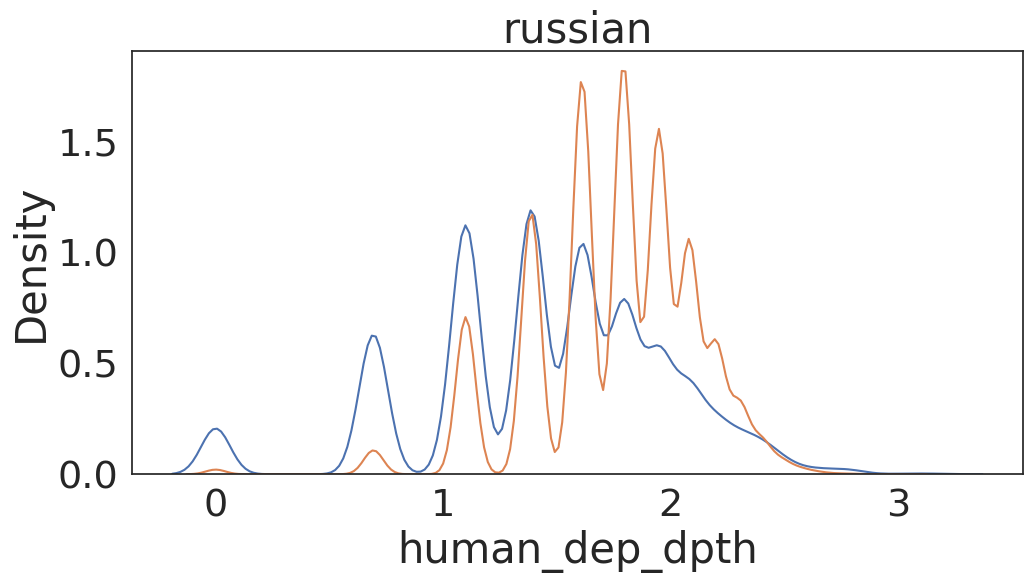

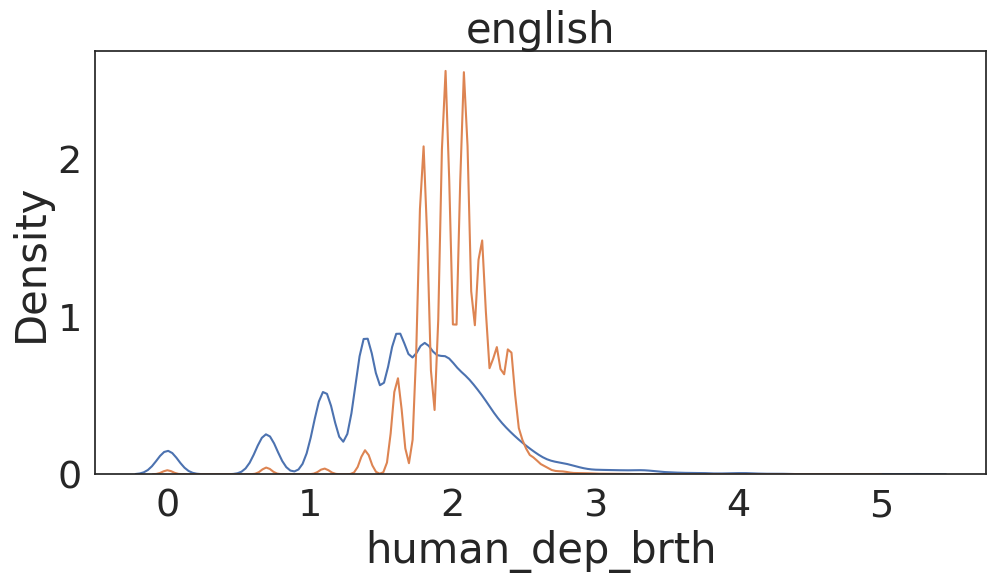

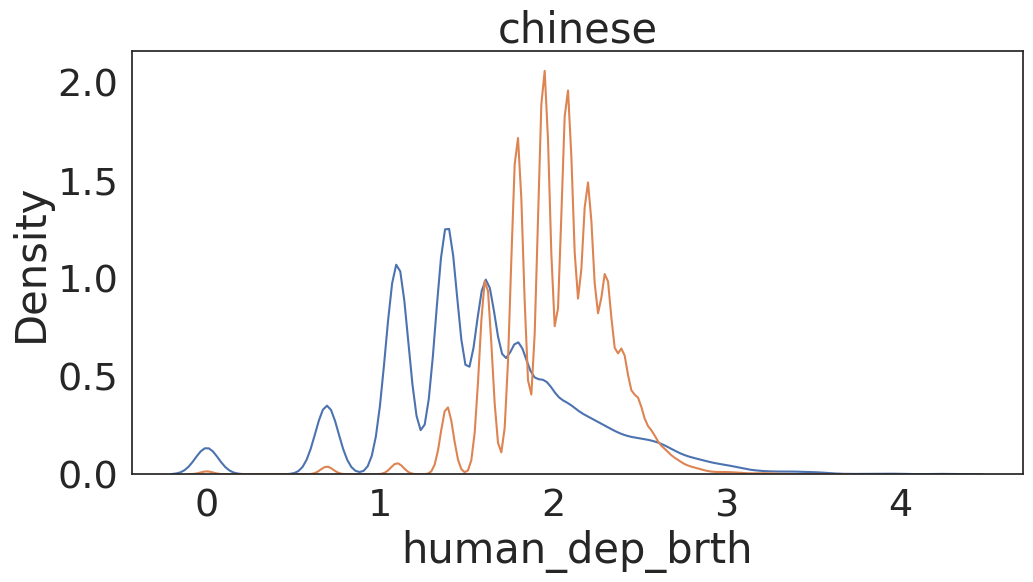

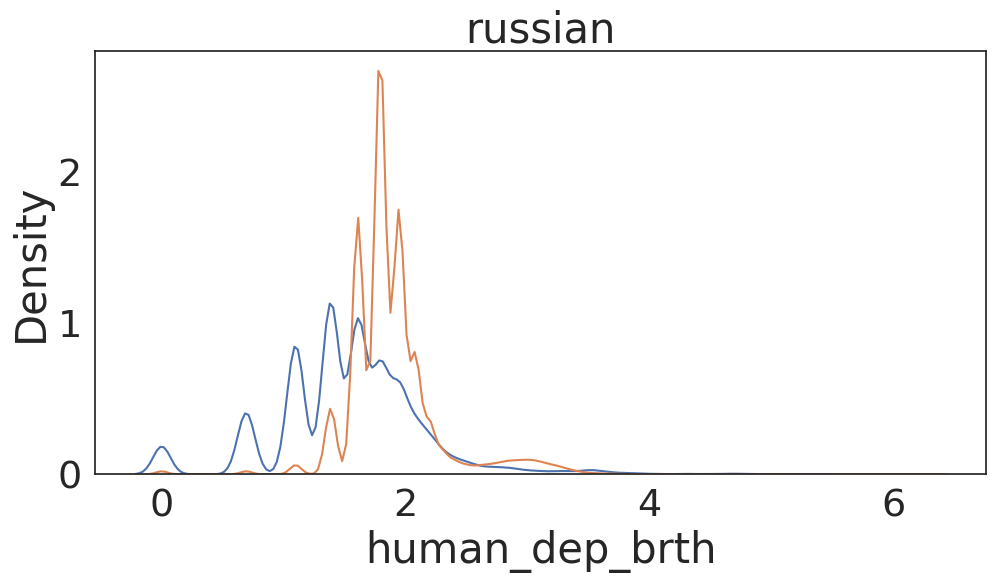

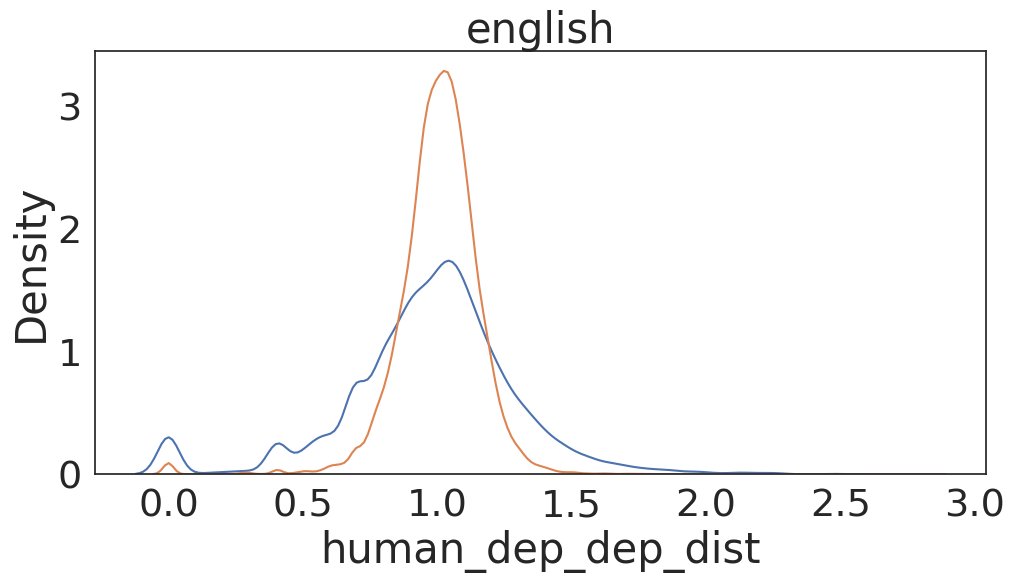

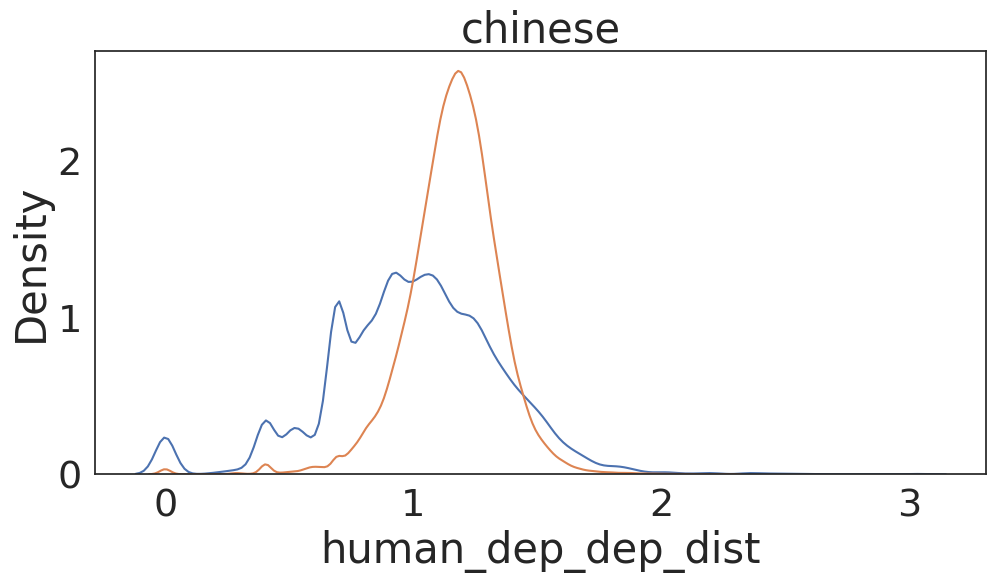

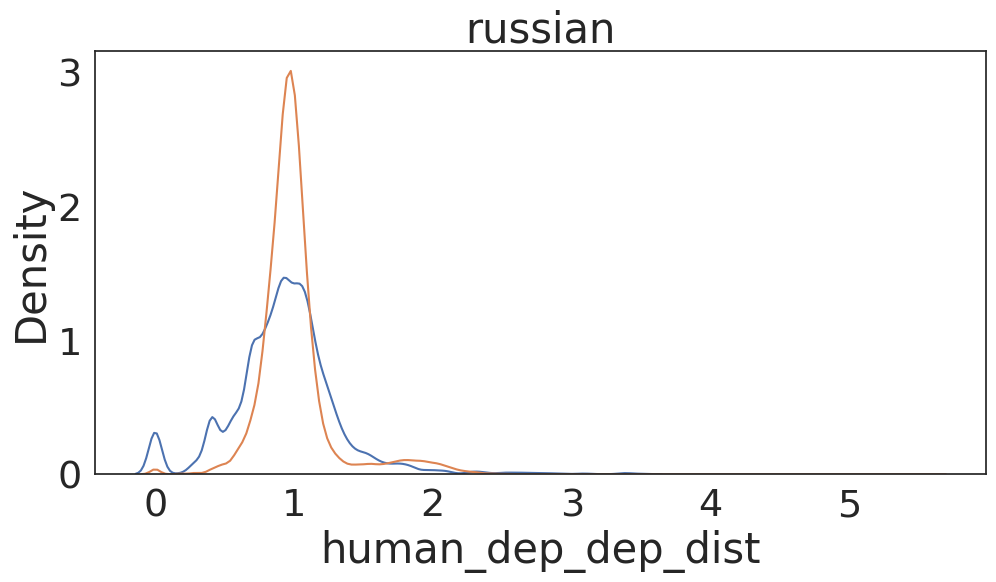

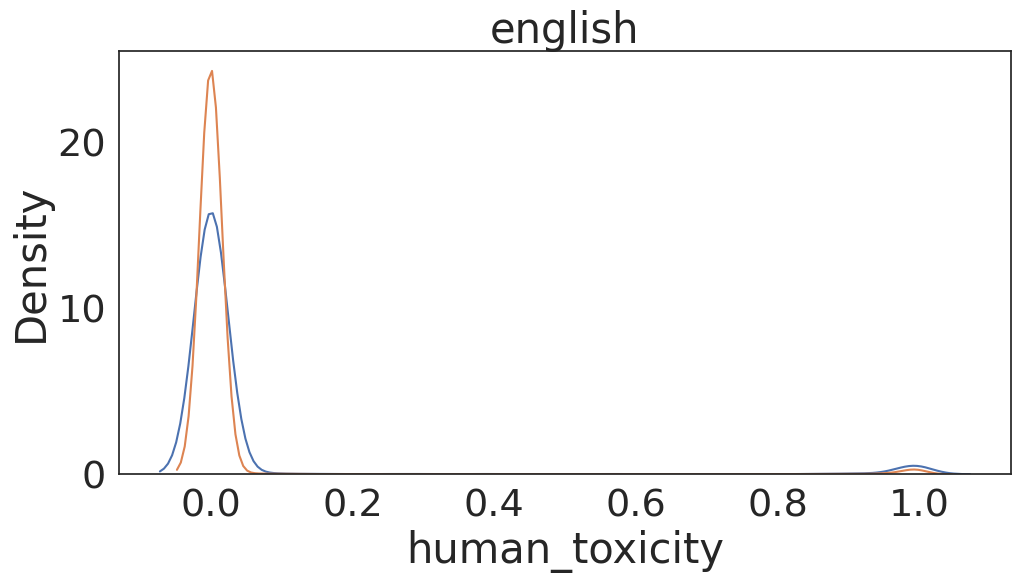

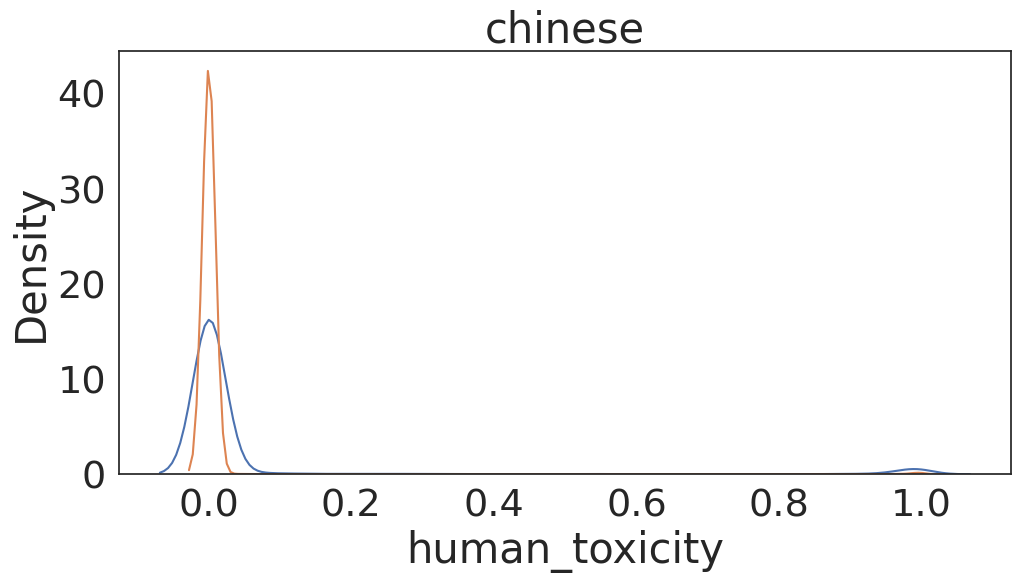

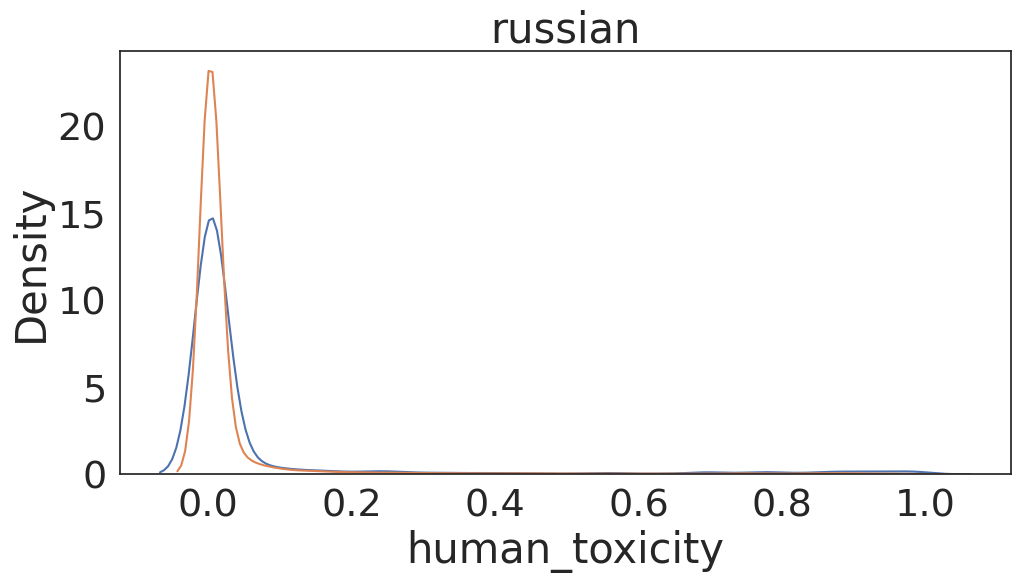

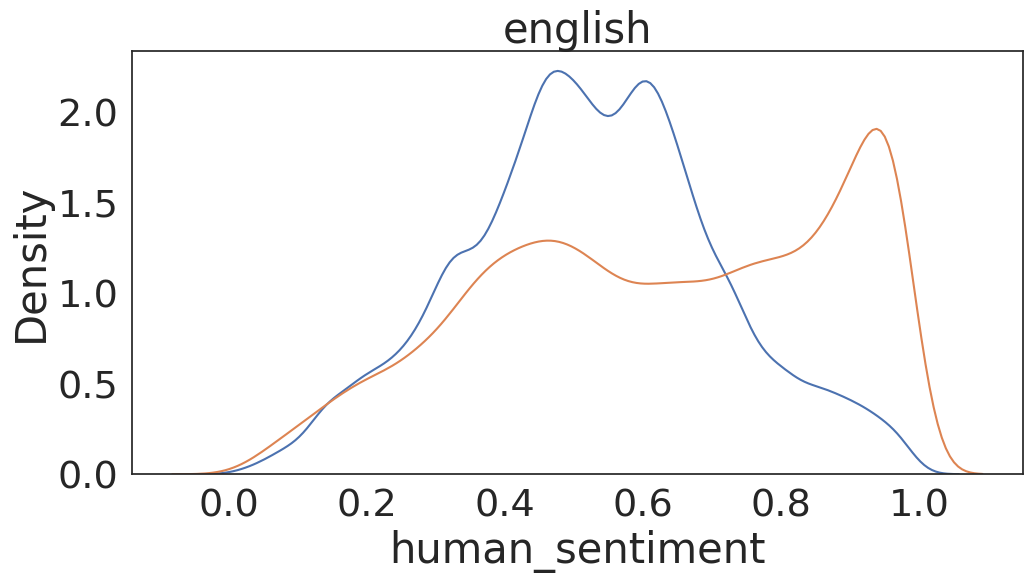

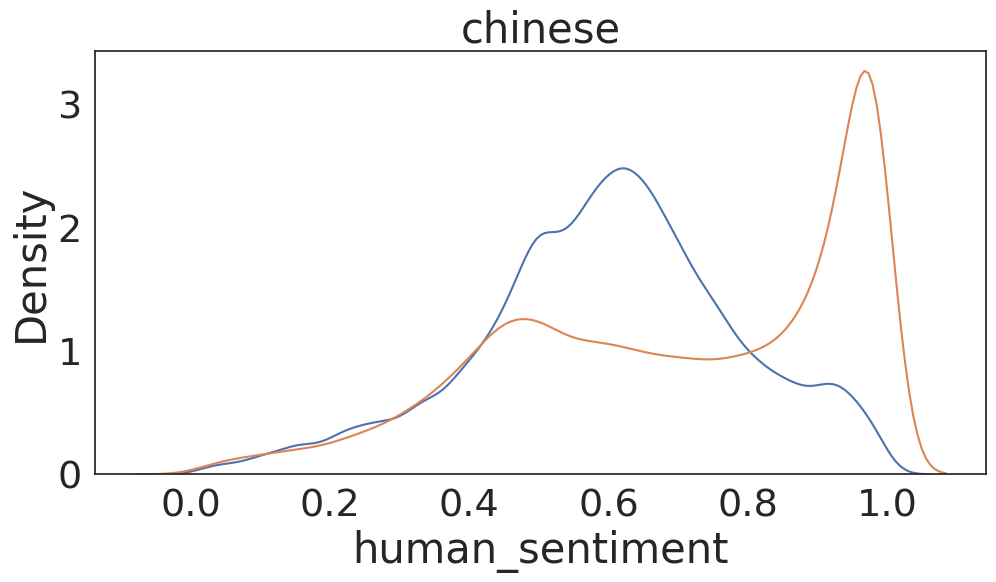

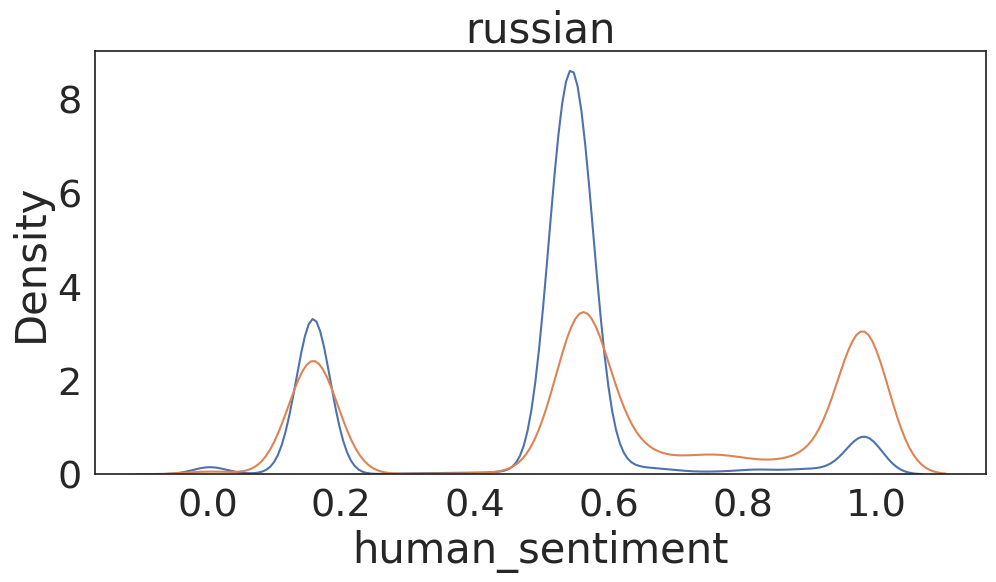

In [191]:
for k in all_metrics:
    if all_metrics[k]=='scalar':
        for lang in ['english','chinese','russian']:
            sns.kdeplot(metrics['human_'+k][metrics.language==lang])
            sns.kdeplot(metrics['llm_'+k][metrics.language==lang])
            plt.title(lang)
            plt.show()

# Correlation

In [ ]:
metrics = pd.read_csv('data/agg_metrics/multilingual_metrics.csv')

In [192]:
# CREATE COLUMN AGGREGATES WITH CORRELATION
def corr_metric(corr_method = 'pearson', var = 'model', lang = 'english', 
                human_prefix='human_', sim_prefix='llm_'):
    vals = []
    metric = []
    cor = []
    sub1 = metrics[metrics.language == lang]
    for lvl in set(sub1[var]):
        print(lvl)
        sub = sub1[sub1[var] == lvl]
        for k in all_metrics:
            #print(k)
            vals.append(lvl)
            metric.append(k)
            cor.append(col_diff_correlate(sub[human_prefix+k], sub[sim_prefix+k], all_metrics[k], corr_method))
    col_corr = pd.DataFrame({var: vals, 'metric': metric, 'cor': cor, 'corr_method': corr_method, 'language':lang})
    col_corr['category'] = col_corr['metric'].replace(metric_category)
    return col_corr

In [193]:
def clean_cor_df(col_corr):
    col_corr = pd.concat(col_corr)
    col_corr['language'] = col_corr['language'].apply(lambda x: x.title())
    col_corr['category'] = col_corr['category'].apply(lambda x: x.title())
    if 'prompt' in col_corr: 
        col_corr['prompt'] = col_corr['prompt'].replace({'Prompt_19':'COT',
                                                          'Prompt_11':'Override',
                                                          'Prompt_15':'Direct'})
        col_corr.sort_values('prompt', )
    col_corr['metric'] = col_corr['metric'].replace({'f1': 'F1 Score',
                                                     'word_count': 'Utterance Len',
                                                     'perplexity': 'Perplexity',
                                                     'pos': 'Part of Speech',
                                                     'dep_dpth': 'Tree Depth',
                                                     'dep_brth': 'Tree Breadth',
                                                     'dep_dep_dist': 'Tree Ave. Dist.',
                                                     'sbert': 'SBERT',
                                                     'punctuation': 'Punctuation',
                                                     'toxicity':'Toxicity',
                                                     'sentiment':'Sentiment'})
    return col_corr

In [194]:
models = []
languages = []
f1 = []
for lang in ['english','chinese','russian']:
    sub1 = all_lang_end[all_lang_end.language==lang]
    for mod in set(sub1.model.tolist()):
        sub = sub1[sub1.model == mod]
        models.append(mod)
        languages.append(lang)
        f1.append(f1_score(sub.human_end, sub.llm_end))
col_corr = [pd.DataFrame({'model':models, 'metric':'f1', 'cor':f1, 'corr_method':'f1',
                          'language':languages, 'category':'Conv End (F1)'})]
col_corr.extend([corr_metric(corr_method='pearson', var = 'model', lang = lang) 
                 for lang in ['english','chinese','russian']])
col_corr = clean_cor_df(col_corr)
col_corr.to_csv('data/agg_metrics/cor_metrics_multilingual_model.csv', index=None)

Mixtral-8x7B
Mistral-Large
Llama-3.1-70B
Mixtral-8x7B
Mistral-Large
Llama-3.1-70B
Mixtral-8x7B
Mistral-Large
Llama-3.1-70B


In [195]:
prompts = []
languages = []
f1 = []
for lang in ['english','chinese','russian']:
    sub1 = all_lang_end[all_lang_end.language==lang]
    for pr in set(sub1.prompt.tolist()):
        sub = sub1[sub1.prompt == pr]
        prompts.append(pr)
        languages.append(lang)
        f1.append(f1_score(sub.human_end, sub.llm_end))
col_corr_prompt = [pd.DataFrame({'prompt':prompts, 'metric':'f1', 'cor':f1, 'corr_method':'f1',
                                 'language':languages, 'category':'Conv End (F1)'})]

col_corr_prompt.extend([corr_metric(corr_method='pearson', var = 'prompt', lang = lang) 
                        for lang in ['english','chinese','russian']])
col_corr_prompt = clean_cor_df(col_corr_prompt)
col_corr_prompt.to_csv('data/agg_metrics/cor_metrics_multilingual_prompt.csv', index=None)

Prompt_19
Prompt_11
Prompt_15
Prompt_19
Prompt_11
Prompt_15
Prompt_19
Prompt_11
Prompt_15


In [196]:
f1 = [f1_score(all_lang_end.human_end[all_lang_end.language==lang], 
               all_lang_end.llm_end[all_lang_end.language==lang])
      for lang in ['english','chinese','russian']]
corr_all = [pd.DataFrame({'metric':'f1', 'cor':f1, 'corr_method':'f1', 
                                    'language':['english','chinese','russian'], 
                                    'category':'Conv End (F1)'})]
corr_method = 'pearson'
for lang in ['english','chinese','russian']:
    metric = []
    cor = []
    sub = metrics[metrics.language == lang]
    for k in all_metrics:
        print(lang, k)
        metric.append(k)
        cor.append(col_diff_correlate(sub['human_'+k], sub['llm_'+k], all_metrics[k], corr_method))
    df = pd.DataFrame({'metric': metric, 'cor': cor, 'corr_method': corr_method, 'language':lang})
    df['category'] = df['metric'].replace(metric_category)
    corr_all.append(df)

corr_all = clean_cor_df(corr_all)
corr_all.to_csv('data/agg_metrics/cor_metrics_multilingual_agg.csv', index=None)

english word_count
english perplexity
english pos
english dep_dpth
english dep_brth
english dep_dep_dist
english sbert
english punctuation
english toxicity
english sentiment
chinese word_count
chinese perplexity
chinese pos
chinese dep_dpth
chinese dep_brth
chinese dep_dep_dist
chinese sbert
chinese punctuation
chinese toxicity
chinese sentiment
russian word_count
russian perplexity
russian pos
russian dep_dpth
russian dep_brth
russian dep_dep_dist
russian sbert
russian punctuation
russian toxicity
russian sentiment


# Plotting

In [31]:
from matplotlib import rcParams


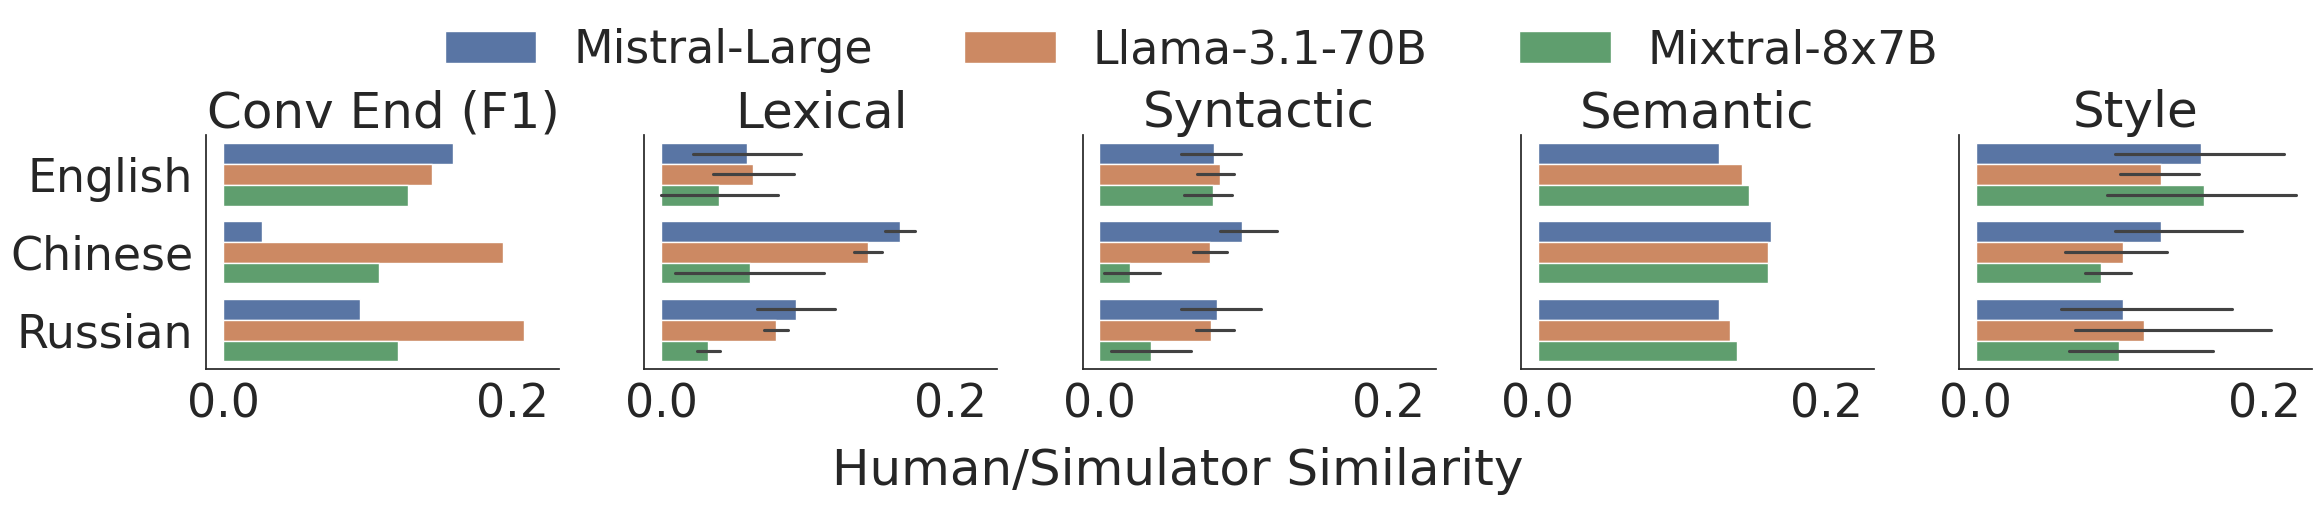

In [201]:
col_corr = pd.read_csv('data/agg_metrics/cor_metrics_multilingual_model.csv')
col_corr.model = col_corr.model.apply(lambda x: re.sub('_metrics|-Instruct','',x))
sns.set(font_scale=3)
sns.set_style(style='white') 

rcParams['figure.figsize'] = 6.5,3.5
g = sns.catplot(kind="bar", data = col_corr,
                x = 'cor', y = 'language', hue = 'model', 
                col = 'category', col_wrap = 5, hue_order = ['Mistral-Large','Llama-3.1-70B','Mixtral-8x7B'])
sns.move_legend(g, loc = 'upper center', ncol = 3, title = '',
                bbox_to_anchor=(0.45, 1.05), borderaxespad=0.)
g.set_titles(template = '{col_name}')
g.set(xlabel='', ylabel='')
g.fig.text(0.33,0.1,'Human/Simulator Similarity')
g.savefig('data/multilingual_model_corr.pdf')

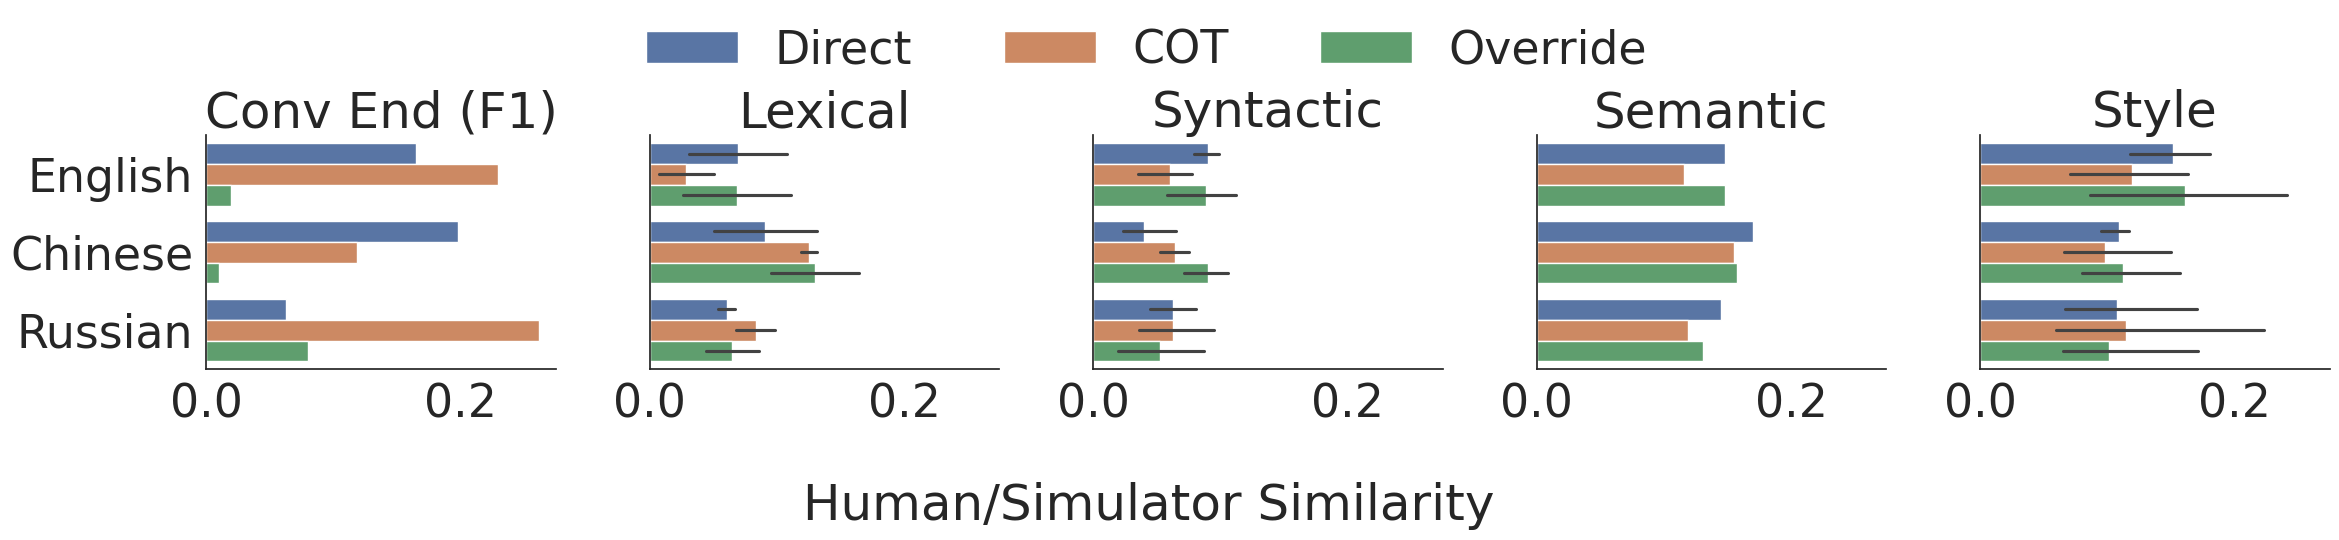

In [202]:
col_corr_prompt = pd.read_csv('data/agg_metrics/cor_metrics_multilingual_prompt.csv')
sns.set(font_scale=3)
sns.set_style(style='white') 

rcParams['figure.figsize'] = 6.5,3.5
g = sns.catplot(kind="bar", data = col_corr_prompt,
                x = 'cor', y = 'language', hue = 'prompt', 
                col = 'category', col_wrap = 5, hue_order = ['Direct','COT','Override'])
sns.move_legend(g, loc = 'upper center', ncol = 4, title = '',
                bbox_to_anchor=(0.45, 1.05), borderaxespad=0.)
g.set_titles(template = '{col_name}')
g.set(xlabel='', ylabel='')
g.fig.text(0.33,0.03,'Human/Simulator Similarity')
g.savefig('data/multilingual_prompt_corr.pdf')

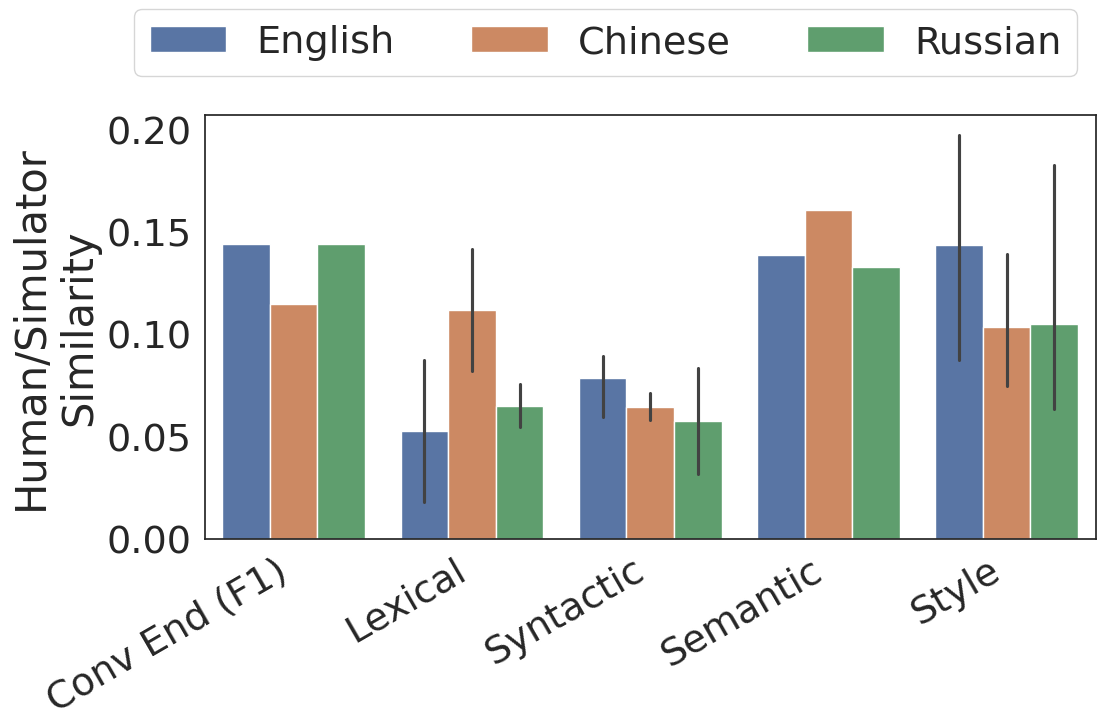

In [203]:
corr_all = pd.read_csv('data/agg_metrics/cor_metrics_multilingual_agg.csv')
sns.set(font_scale=2.5)
sns.set_style(style='white') 

rcParams['figure.figsize'] = 11.5,5.5
g = sns.barplot(data = corr_all,
                y = 'cor', x = 'category', hue = 'language', 
                hue_order = ['English','Chinese','Russian'])
sns.move_legend(g, loc = 'upper center', ncol = 4, title = '',
                bbox_to_anchor=(0.45, 1.25), borderaxespad=0.)
g.set(xlabel='', ylabel='Human/Simulator\nSimilarity')
plt.xticks(rotation=30, ha='right')
plt.savefig('data/multilingual_corr.pdf', bbox_inches='tight')

(array([0. , 0.1, 0.2, 0.3]),
 [Text(0.0, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3')])

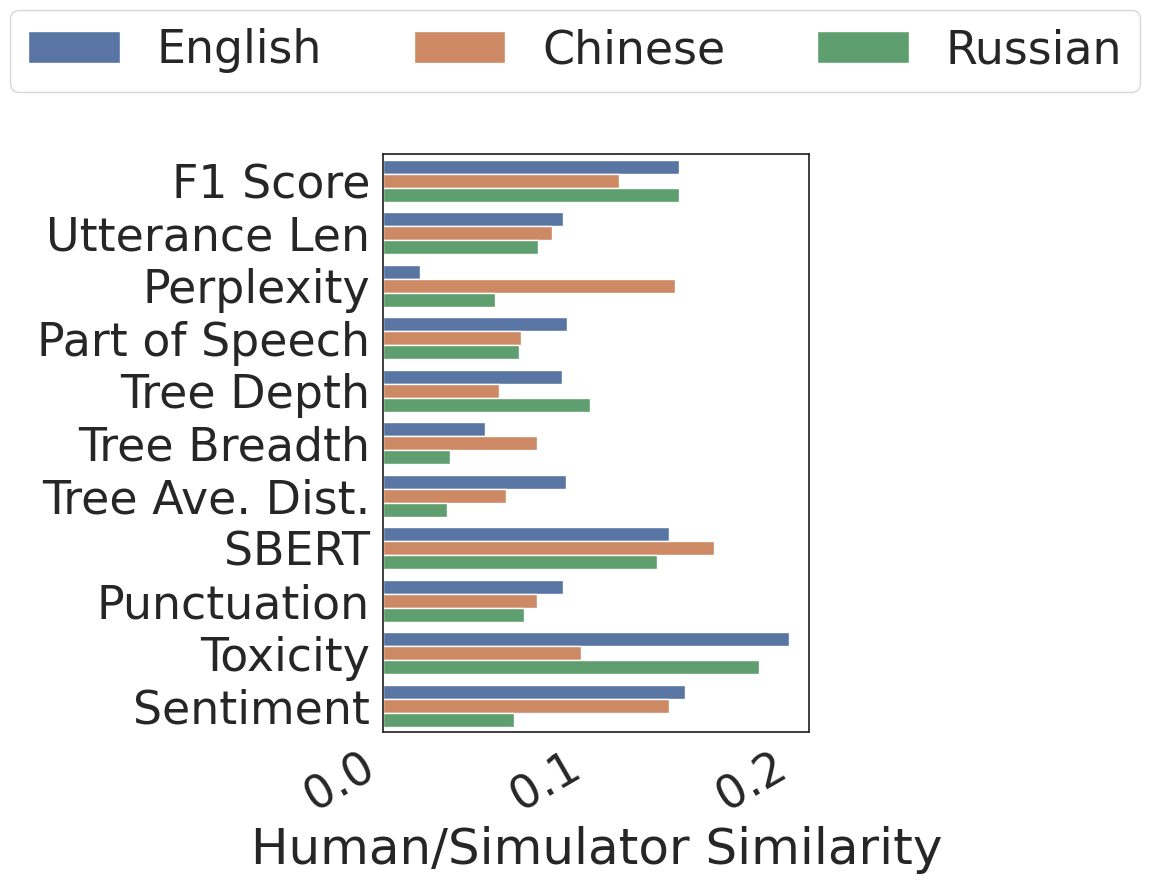

In [204]:
corr_all = pd.read_csv('data/agg_metrics/cor_metrics_multilingual_agg.csv')
sns.set(font_scale=3)
sns.set_style(style='white') 

rcParams['figure.figsize'] = 5.5,7.5
g = sns.barplot(data = corr_all,
                x = 'cor', y = 'metric', hue = 'language', 
                hue_order = ['English','Chinese','Russian'])
sns.move_legend(g, loc = 'upper center', ncol = 4, title = '',
                bbox_to_anchor=(0.45, 1.25), borderaxespad=0.)
g.set(ylabel='', xlabel='Human/Simulator Similarity')
plt.xticks(rotation=30, ha='right')

[Text(0, 0.5, ''), Text(0.5, 0, 'Human/Simulator Similarity')]

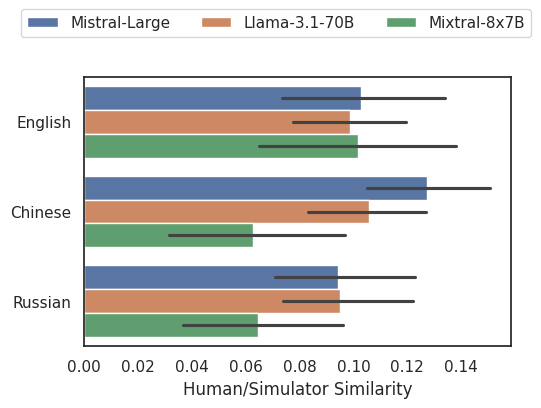

In [234]:
rcParams['figure.figsize'] = 5.5,3.5
g = sns.barplot(data = col_corr[col_corr.metric != 'F1 Score'],
                x = 'cor', y = 'language', hue = 'model',
                hue_order = ['Mistral-Large','Llama-3.1-70B','Mixtral-8x7B'])
sns.move_legend(g, loc = 'upper center', ncol = 4, title = '',
                bbox_to_anchor=(0.45, 1.25), borderaxespad=0.)
g.set(ylabel='', xlabel='Human/Simulator Similarity')

[Text(0, 0.5, ''), Text(0.5, 0, 'Human/Simulator Similarity')]

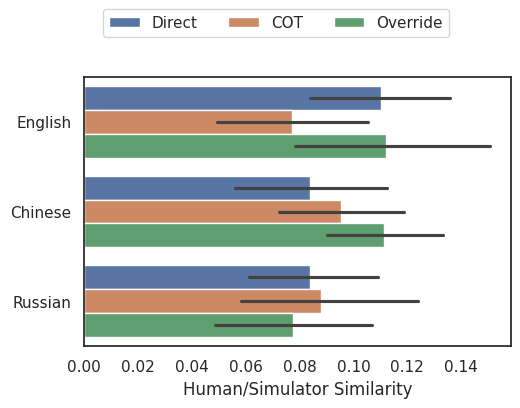

In [235]:
rcParams['figure.figsize'] = 5.5,3.5
g = sns.barplot(data = col_corr_prompt[col_corr_prompt.metric!='F1 Score'],
                x = 'cor', y = 'language', hue = 'prompt',
                hue_order = ['Direct','COT','Override']
               )
sns.move_legend(g, loc = 'upper center', ncol = 4, title = '',
                bbox_to_anchor=(0.45, 1.25), borderaxespad=0.)
g.set(ylabel='', xlabel='Human/Simulator Similarity')

In [223]:
for lang in set(all_lang_end.language):
    for prompt in set(all_lang_end.prompt):
        cond = (all_lang_end.language==lang) & (all_lang_end.prompt==prompt)
        print(lang, prompt, sum(cond))
        print(np.mean(all_lang_end.human_end[cond]), 
              np.mean(all_lang_end.llm_end[cond]))
        print(f1_score(all_lang_end.human_end[cond], 
                       all_lang_end.llm_end[cond]))
        p = np.mean(all_lang_end.llm_end[cond])
        print(f1_score(all_lang_end.human_end[cond], 
                       [1 if random.random() < p else 0 for _ in range(sum(cond))]))
        print(f1_score(all_lang_end.human_end[cond], 
                       [1 if random.random() < 0.5 else 0 for _ in range(sum(cond))]))
        print()


english Prompt_19 300000
0.64384 0.13265333333333335
0.22931297972079606
0.2208970858447959
0.5635573359573558

english Prompt_11 300000
0.64384 0.01028
0.018936382722843922
0.020113155614455376
0.5633749449857619

english Prompt_15 300000
0.64384 0.08434666666666667
0.16491192734463692
0.14921463571003343
0.5630885341750185

russian Prompt_19 30000
0.541 0.1618
0.26162018592297476
0.2479221087627642
0.5224787363304981

russian Prompt_11 30000
0.541 0.031166666666666665
0.07981357413341102
0.05842644320297952
0.5213200561726031

russian Prompt_15 30000
0.541 0.024333333333333332
0.062264150943396226
0.044599138693882365
0.5156535392700355

chinese Prompt_19 30000
0.4487 0.05993333333333333
0.11835637984140507
0.09971022128556375
0.4646187409831451

chinese Prompt_11 30000
0.4487 0.004633333333333333
0.01
0.009987515605493134
0.4752315464496211

chinese Prompt_15 30000
0.4487 0.0985
0.19749025341130605
0.1655323286339329
0.472406646292198



In [268]:
plot_df

,language,human_end,llm_end
1,English,Conversation Continues,0.067398
1,English,Conversation Ends,0.080386
0,Chinese,Conversation Continues,0.046355
0,Chinese,Conversation Ends,0.064185
2,Russian,Conversation Continues,0.061680
2,Russian,Conversation Ends,0.081557


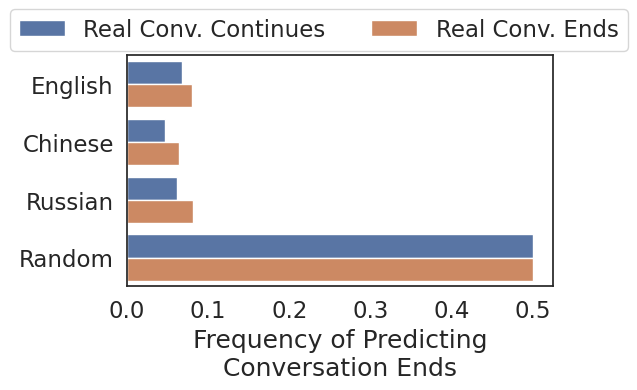

In [284]:
rcParams['figure.figsize'] = 5.5,3
sns.set(font_scale=1.5)
sns.set_style(style='white') 
plot_df = pd.concat([all_lang_end[all_lang_end.human_end==0].groupby(['language'])[['human_end','llm_end']].mean().reset_index(),
                     all_lang_end[all_lang_end.human_end==1].groupby(['language'])[['human_end','llm_end']].mean().reset_index()])
plot_df = pd.concat([plot_df, pd.DataFrame({'language':'Random', 'llm_end':0.5, 'human_end':[0,1]})])
plot_df.language = plot_df.language.apply(lambda x: x.title())
plot_df.language = plot_df.language.astype('category')
plot_df.language = plot_df.language.cat.set_categories(['English','Chinese','Russian','Random'])
plot_df = plot_df.sort_values(['language'])
plot_df.human_end = plot_df.human_end.replace({0:'Real Conv. Continues',1:"Real Conv. Ends"})

g = sns.barplot(data = plot_df, x = 'llm_end', y = 'language', hue = 'human_end')
g.set(ylabel = '', xlabel = 'Frequency of Predicting\nConversation Ends')
sns.move_legend(g, loc = 'upper center', ncol = 4, title = '',
                bbox_to_anchor=(0.45, 1.2), borderaxespad=0.)
plt.savefig('data/multilingual_f1.pdf', bbox_inches='tight')

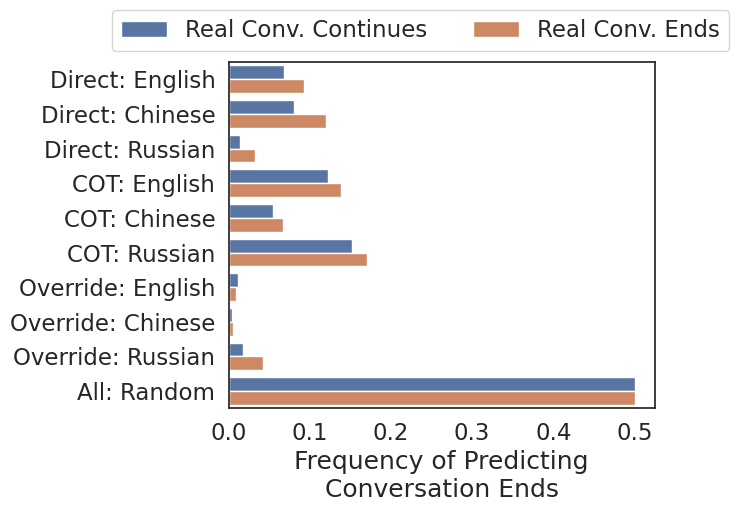

In [285]:
rcParams['figure.figsize'] = 5.5,4.5
sns.set(font_scale=1.5)
sns.set_style(style='white') 
plot_df = pd.concat([all_lang_end[all_lang_end.human_end==0].groupby(['prompt','language'])[['human_end','llm_end']].mean().reset_index(),
                     all_lang_end[all_lang_end.human_end==1].groupby(['prompt','language'])[['human_end','llm_end']].mean().reset_index()])
plot_df = pd.concat([plot_df, pd.DataFrame({'prompt':'All','language':'Random', 'llm_end':0.5, 'human_end':[0,1]})])
plot_df.language = plot_df.language.apply(lambda x: x.title())
plot_df.language = plot_df.language.astype('category')
plot_df.language = plot_df.language.cat.set_categories(['English','Chinese','Russian','Random'])
plot_df.prompt = plot_df.prompt.replace({'Prompt_11':'Override', 'Prompt_15':'Direct', 'Prompt_19':'COT'})
plot_df.prompt = plot_df.prompt.astype('category')
plot_df.prompt = plot_df.prompt.cat.set_categories(['Direct','COT','Override','All'])
plot_df = plot_df.sort_values(['prompt','language'])
plot_df['y'] = plot_df['prompt'].astype('str') + ': ' + plot_df['language'].astype('str')
plot_df.human_end = plot_df.human_end.replace({0:'Real Conv. Continues',1:"Real Conv. Ends"})

g = sns.barplot(data = plot_df, x = 'llm_end', y = 'y', hue = 'human_end')
g.set(ylabel = '', xlabel = 'Frequency of Predicting\nConversation Ends')
sns.move_legend(g, loc = 'upper center', ncol = 4, title = '',
                bbox_to_anchor=(0.45, 1.15), borderaxespad=0.)


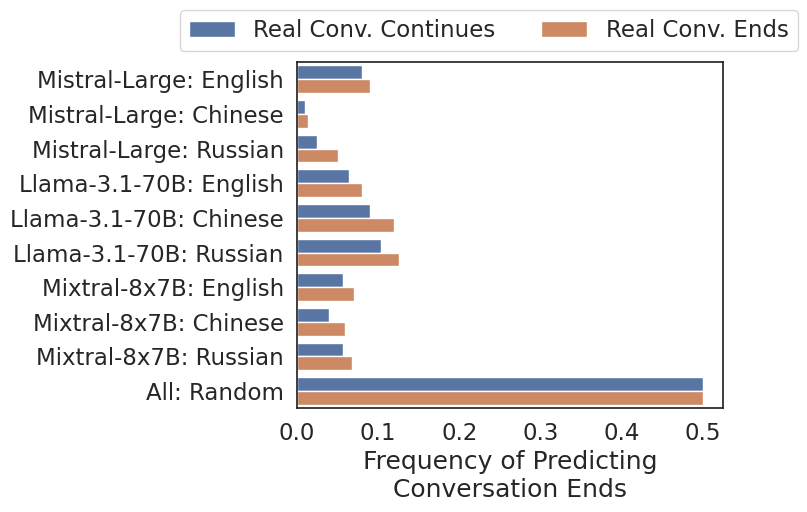

In [286]:
rcParams['figure.figsize'] = 5.5,4.5
sns.set(font_scale=1.5)
sns.set_style(style='white') 
plot_df = pd.concat([all_lang_end[all_lang_end.human_end==0].groupby(['model','language'])[['human_end','llm_end']].mean().reset_index(),
                     all_lang_end[all_lang_end.human_end==1].groupby(['model','language'])[['human_end','llm_end']].mean().reset_index()])
plot_df = pd.concat([plot_df, pd.DataFrame({'model':'All','language':'Random', 'llm_end':0.5, 'human_end':[0,1]})])
plot_df.language = plot_df.language.apply(lambda x: x.title())
plot_df.language = plot_df.language.astype('category')
plot_df.language = plot_df.language.cat.set_categories(['English','Chinese','Russian','Random'])
plot_df.model = plot_df.model.astype('category')
plot_df.model = plot_df.model.cat.set_categories(['Mistral-Large','Llama-3.1-70B','Mixtral-8x7B','All'])
plot_df = plot_df.sort_values(['model','language'])
plot_df['y'] = plot_df['model'].astype('str') + ': ' + plot_df['language'].astype('str')
plot_df.human_end = plot_df.human_end.replace({0:'Real Conv. Continues',1:"Real Conv. Ends"})

g = sns.barplot(data = plot_df, x = 'llm_end', y = 'y', hue = 'human_end')
g.set(ylabel = '', xlabel = 'Frequency of Predicting\nConversation Ends')
sns.move_legend(g, loc = 'upper center', ncol = 4, title = '',
                bbox_to_anchor=(0.45, 1.15), borderaxespad=0.)

# Misc Stuff

In [37]:
df_zscore = metrics[merge_keys+['language']]
for k in all_metrics:
    df_zscore.loc[:,'zscore_'+k] = diff_zscore(metrics['human_'+k], metrics['llm_'+k], 
                                               all_metrics[k], p=1)


In [38]:
df_zscore.to_csv('data/agg_metrics/multilingual_dvs.csv', index=None)

In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
plt_df = []
for c in df_zscore:
    if c.startswith('zscore'):
        
        mod = smf.ols(formula = c + " ~ C(language, Treatment('english')) * "+
                          "(C(model, Treatment('Mixtral-8x7B')) + C(prompt, Treatment('Prompt_15')))", 
              data=df_zscore)
        res = mod.fit()
        
        plt = res.conf_int(alpha=0.05 / 9)
        plt.columns = ['lo','hi']
        plt['beta'] = res.params
        
        plt['outcome'] = c
        plt_df.append(plt)

plt_df = pd.concat(plt_df).reset_index()

In [40]:
plt_df['language'] = plt_df['index'].apply(lambda x: 'chinese' if bool(re.search('T.chinese',x))
                                                     else 'russian' if bool(re.search('T.russian',x))
                                                     else 'english'
                                          )
Counter(plt_df['language'])

Counter({'english': 40, 'chinese': 40, 'russian': 40})

In [41]:
plt_df['model'] = plt_df['index'].apply(lambda x: 'Llama-3.1-70B' if bool(re.search('T.Llama-3.1-70B',x))
                                                     else 'Mistral-Large' if bool(re.search('T.Mistral-Large',x))
                                                     else 'Mixtral-8x7B'
                                          )
Counter(plt_df['model'])

Counter({'Mixtral-8x7B': 72, 'Llama-3.1-70B': 24, 'Mistral-Large': 24})

In [42]:
plt_df['prompt'] = plt_df['index'].apply(lambda x: 'Override' if bool(re.search('T.Prompt_11',x))
                                                     else 'COT' if bool(re.search('T.Prompt_19',x))
                                                     else 'Direct'
                                          )
Counter(plt_df['prompt'])

Counter({'Direct': 72, 'Override': 24, 'COT': 24})

<Axes: xlabel='beta', ylabel='outcome'>

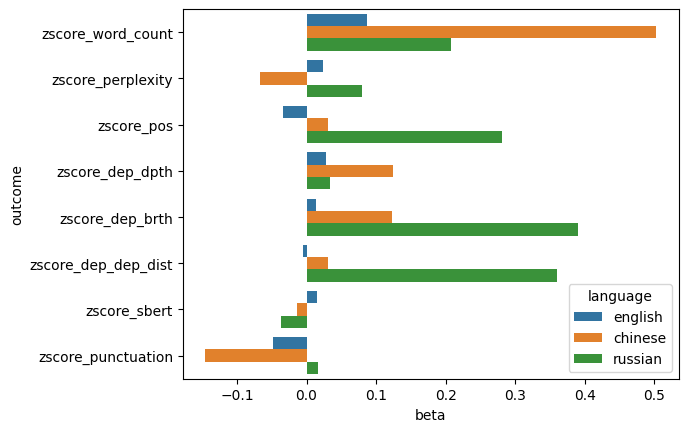

In [43]:
sns.barplot(data = plt_df[(plt_df.model=='Llama-3.1-70B') & (plt_df.prompt=='Direct')],
              y = 'outcome', x = 'beta', hue = 'language')

In [17]:
df_zscore.merge(metrics[[c for c in metrics.columns if not 'turn_3_' in c]], on=merge_keys, how='inner').\
to_csv('data/regression_100k_data/regression_data_metrics_'+language+'.csv', index=None)


In [18]:
df_zscore.merge(metrics[[c for c in metrics.columns if not 'turn_3_' in c]], on=merge_keys, how='inner').columns.tolist()



['conversation_hash',
 'hashed_ip',
 'model',
 'prompt',
 'zscore_log_word_count',
 'zscore_perplexity',
 'zscore_alnum_ratio',
 'zscore_sbert_embedding',
 'zscore_punctuation',
 'zscore_sentiment',
 'zscore_toxicity',
 'country',
 'language',
 'turn',
 'toxic',
 'human_turn_1_sbert_embedding',
 'ai_turn_2_sbert_embedding',
 'human_turn_1_log_word_count',
 'ai_turn_2_log_word_count',
 'human_turn_1_alnum_ratio',
 'ai_turn_2_alnum_ratio',
 'human_turn_1_punctuation',
 'ai_turn_2_punctuation',
 'human_turn_1_sentiment',
 'ai_turn_2_sentiment',
 'human_turn_1_toxicity',
 'ai_turn_2_toxicity',
 'human_turn_1_perplexity',
 'ai_turn_2_perplexity']

In [19]:
for f in os.listdir(base_dir):
    if f.endswith('_end.jsonl'):
        print(f)

wildchat_subset_cn_10k_Mixtral-8x7B-Instruct_metrics_end.jsonl
wildchat_subset_cn_10k_Llama-3.1-70B-Instruct_metrics_end.jsonl
wildchat_subset_cn_10k_Mistral-Large-Instruct_metrics_end.jsonl


In [33]:
language = 'chinese'
base_dir = 'data/'+language+'_only/with_metrics/' #experiment 3
def make_end_df(base_dir, f):
    print(f)
    df = pd.read_json(base_dir + f, orient='records', lines=True)
    #df = df[[c for c in df.columns if c in merge_keys or c in ['human_end', 'llm_end']]]
    df['model'] = re.sub('.jsonl','',f)
    return df

metrics_end = pd.concat([make_end_df(base_dir, f) for f in os.listdir(base_dir)
                         if f.endswith('_end.jsonl')])
#metrics_end.to_csv('data/regression_100k_data/regression_data_metrics_'+language+'_logistic.csv', index=None)
metrics_end

wildchat_subset_cn_10k_Mixtral-8x7B-Instruct_metrics_end.jsonl
wildchat_subset_cn_10k_Llama-3.1-70B-Instruct_metrics_end.jsonl
wildchat_subset_cn_10k_Mistral-Large-Instruct_metrics_end.jsonl


,human_turn_1,ai_turn_2,human_turn_3,hashed_ip,model,country,language,conversation_hash,turn,toxic,prompt,llm_turn_3,human_end,llm_end,metric_end
0,你好,你好！有什么可以帮助你的吗？,我想写一本小说，关键词是魔法，解析，异兽，副本流派，分享知识，感动，轻松，它的大纲应该怎么写？,451ea909a107a0cedcc9216677253491c3bc73951799b2...,wildchat_subset_cn_10k_Mixtral-8x7B-Instruct_m...,Vietnam,Chinese,04362d3a8fdbcb380768ae9fbafd55d9,4,False,Prompt_11,"哦，你好！我只是想闲逛一下，看看你到底能做什么。不用特意招待我。""",0,0,1
1,学习习近平旗帜鲜明讲政治,学习习近平旗帜鲜明讲政治，首先需要了解习近平的思想理论和政治观，在此基础上深入学习他在领导中...,学习习近平旗帜鲜明讲政治的意义,1101f39531def63fee56bdc3b518b278a24e8fc6ac8fb1...,wildchat_subset_cn_10k_Mixtral-8x7B-Instruct_m...,Hong Kong,Chinese,b876dc9dc5b872b02211425a66ee1ff5,3,False,Prompt_11,哇，谢谢你的详细解释！习近平真是中国共产党和国家事务的核心，他的思想和实践值得我们深入学习。...,0,0,1
2,；高校比赛管理系统的成绩管理模块的需求分析（需求分析描述格式：定义（文字描述，场景实物，结构...,【定义】\n成绩管理模块是高校比赛管理系统的一个子模块，用于对参与比赛的学生的成绩进行管理和...,高校比赛管理系统的奖项管理模块的需求分析（需求分析描述格式：定义（文字描述，场景实物，结构）...,97e4e08b4bcfcb8ad72916a814f30af3fec70094096418...,wildchat_subset_cn_10k_Mixtral-8x7B-Instruct_m...,Taiwan,Chinese,5d3080b5debc38fa9092a092563642d0,4,False,Prompt_11,哦，看起来这个成绩管理模块很有用，我 wondering 如果我是管理员，怎么操作去录入我的...,0,0,1
3,辅助通信系统的op是什么意思,"""op"" 在辅助通信系统中通常是指 ""operator"" ，即操作员或运营商。操作员是指管理...",ergodic capacity是什么意思,45a5d5b92b226a2a991e515787a2036814b1c650c30200...,wildchat_subset_cn_10k_Mixtral-8x7B-Instruct_m...,China,Chinese,2d6041e1acdb386a260bbd2daddb7657,6,False,Prompt_11,"Oh, I see. So an 'op' in a communication assis...",0,0,1
4,"你是IT解决方案专家,请提供简报PPT《测试工具与框架评估》中介绍"" 测试工具与框架的部署与...",【主题名称】：测试工具与框架的部署与集成方案\n\n【关键要点】：\n1. 工具与框架的选择...,[no response],2f7de5f7e98022383379c1d0eb50a14edbcaafe6b9b8df...,wildchat_subset_cn_10k_Mixtral-8x7B-Instruct_m...,United States,Chinese,cb9f78d233eeb5ee13cb2b469e92226b,1,False,Prompt_11,感谢您提供的信息，它真的很有用。我想 deeper 到一些主题，比如第三个主题「自动化与持续...,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,写一段鼓励学弟学妹的话， 高考加油，祝福学校，感谢老师，多饮用诗句,亲爱的学弟学妹们，高考加油！在这个阶段，你们已经历经了漫长的苦读，也许有过挫折和焦虑，但是，...,写一段鼓励学弟学妹的话， 高考加油，祝福学校，感谢老师，多用诗句,5280c4bd5a2d5cbea393599cd4d24840552fb327aa28af...,wildchat_subset_cn_10k_Mistral-Large-Instruct_...,China,Chinese,9051cac4223aff01931b38a4e645a010,2,False,Prompt_19,谢谢你的鼓励！不过我希望能加入一些诗句，能不能再改进一下？,0,0,1
29996,- (void)userNotificationCenter:(UNUserNotifica...,这段代码是实现了 `UNUserNotificationCenterDelegate` 协议...,报这个错误是什么原因：Use of undeclared identifier 'kGCMM...,1c1437e0fe9785a9bde89972db93808d7e73ff5c5e5265...,wildchat_subset_cn_10k_Mistral-Large-Instruct_...,Hong Kong,Chinese,cf5447d40e8135d480dc30b12d58791e,12,False,Prompt_19,谢谢你的解释。请问 `kGCMMessageIDKey` 是什么？它在 Firebase M...,0,0,1
29997,难以忘怀的一天,作为人工智能，我无法经历和感受到人类的情感，但我可以讲述关于难以忘怀的一天的故事。\n\n这...,[no response],915b9990d408014a1bc2104834f0067ca9a8977d8db68f...,wildchat_subset_cn_10k_Mistral-Large-Instruct_...,Malaysia,Chinese,fe20ef9087d9aa3ef428cbcbf97e427c,1,False,Prompt_19,你的故事很感人。我也有一个难以忘怀的一天，那是我第一次带着家人去旅行的时候。你愿意听听我的故事吗？,1,0,0
29998,改写下面的工作内容，使用另一种表达方式：内容:\n一、根据业务需求调研大模型的基本训练方法，...,重新整理工作内容如下：\n1. 调研各种文本大模型，熟悉它们的基本使用方法，根据客户需求进行...,[no response],af5a0b1aae9b74182c7713ac2438a67c9f2698cbf8dbae...,wildchat_subset_cn_10k_Mistral-Large-Instruct_...,United States,Chinese,1c62356ae45b0fc45d55b30d9deb0c88,1,False,Prompt_19,谢谢，这样的表达更加简洁明了。你能再稍微调整一下第三点的表达吗？我觉得还可以更简洁一些。,1,0,0


In [34]:
from sklearn.metrics import f1_score

In [35]:
for mod in set(metrics_end.model):
    cond = metrics_end.model==mod
    print(mod, f1_score(metrics_end.human_end[cond], metrics_end.llm_end[cond]))
    

wildchat_subset_cn_10k_Mixtral-8x7B-Instruct_metrics_end 0.10793054903801032
wildchat_subset_cn_10k_Mistral-Large-Instruct_metrics_end 0.026514053897421036
wildchat_subset_cn_10k_Llama-3.1-70B-Instruct_metrics_end 0.1937900205388426


In [36]:
for mod in set(metrics_end.prompt):
    cond = metrics_end.prompt==mod
    print(mod, f1_score(metrics_end.human_end[cond], metrics_end.llm_end[cond]))
    

Prompt_15 0.19749025341130605
Prompt_11 0.01
Prompt_19 0.11835637984140507


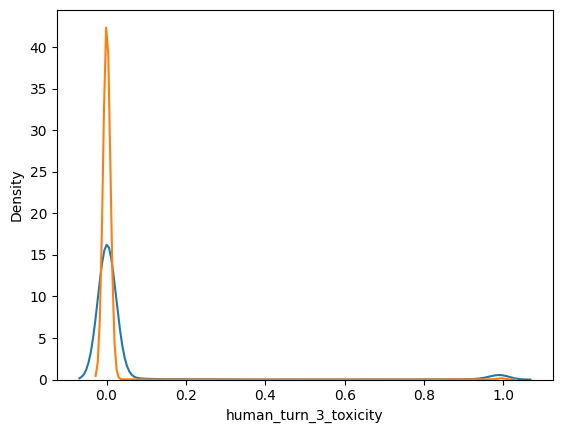

In [40]:
sns.kdeplot(metrics.human_turn_3_toxicity)
sns.kdeplot(metrics.llm_turn_3_toxicity)
plt.show()

In [ ]:
for k in all_metrics:
    df_zscore.loc[:,'zscore_'+k] = diff_zscore(metrics['human_turn_3_'+k], metrics['llm_turn_3_'+k], 
                                               all_metrics[k], p=1)


In [48]:
all_metrics

{'log_word_count': 'scalar',
 'perplexity': 'scalar',
 'alnum_ratio': 'scalar',
 'sbert_embedding': 'vector',
 'punctuation': 'distribution',
 'sentiment': 'scalar',
 'toxicity': 'scalar'}

In [53]:
def read_lang_df(language):
    df = pd.read_csv('data/agg_metrics/'+language+'_metrics.csv')
    df.columns = [re.sub('turn_3_|log_','',x) for x in df.columns]
    df['language'] = language
    return df
all_langs = pd.concat([read_lang_df(language)
                       for language in ['english','chinese','russian']])

In [54]:
all_langs.columns

Index(['hashed_ip', 'model', 'conversation_hash', 'prompt',
       'human_capitalization', 'human_formality', 'human_liwc',
       'human_perplexity', 'human_politeness', 'human_punctuation',
       'human_readability', 'human_sentiment', 'human_subjectivity',
       'human_topic', 'human_toxicity', 'human_typo', 'human_word_length',
       'llm_capitalization', 'llm_formality', 'llm_liwc', 'llm_perplexity',
       'llm_politeness', 'llm_punctuation', 'llm_readability', 'llm_sentiment',
       'llm_subjectivity', 'llm_topic', 'llm_toxicity', 'llm_typo',
       'llm_word_length', 'human_word_count', 'llm_word_count', 'human_pos',
       'llm_pos', 'human_dep_dpth', 'human_dep_brth', 'human_dep_dep_dist',
       'llm_dep_dpth', 'llm_dep_brth', 'llm_dep_dep_dist', 'human_sbert',
       'llm_sbert', 'human_luar', 'llm_luar', 'language', 'country', 'turn',
       'toxic', 'human_turn_1_sbert_embedding', 'ai_turn_2_sbert_embedding',
       'human_sbert_embedding', 'llm_sbert_embedding', 'hum

In [55]:
all_metrics

{'log_word_count': 'scalar',
 'perplexity': 'scalar',
 'alnum_ratio': 'scalar',
 'sbert_embedding': 'vector',
 'punctuation': 'distribution',
 'sentiment': 'scalar',
 'toxicity': 'scalar'}

In [47]:
for k in ['word_count','punctuation']:
    all_langs.loc[:,'zscore_'+k] = diff_zscore(all_langs['human_turn_3_'+k], all_langs['llm_turn_3_'+k], 
                                               all_metrics[k], p=1)


,hashed_ip,model,conversation_hash,prompt,human_capitalization,human_formality,human_liwc,human_perplexity,human_politeness,human_punctuation,...,human_turn_1_sentiment,ai_turn_2_sentiment,human_turn_3_toxicity,llm_turn_3_toxicity,human_turn_1_toxicity,ai_turn_2_toxicity,human_turn_3_perplexity,llm_turn_3_perplexity,human_turn_1_perplexity,ai_turn_2_perplexity
0,568ecf3349b46c238268f63bcdbb2e12cd88feea3052b9...,wildchat_subset_en_100k_Mistral-Large-Instruct,231dc924f9bf607871bf3e5699930833,Prompt_11,0.028571,0.005129,"{'achieve': 0.0, 'affect': 0.0, 'anger': 0.0, ...",5.074333,0.120022,"{'!': 0.0, '""': 0.0, '#': 0.0, '$': 0.0, '%': ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,d3c81b62172c8e48ca874e118ee957e3db84d1f9b4d5b1...,wildchat_subset_en_100k_Mistral-Large-Instruct,edf58f8e33a00f9c374d448aad703650,Prompt_11,0.000000,0.001496,"{'achieve': 0.0, 'affect': 0.0, 'anger': 0.0, ...",3.311915,0.984959,"{'!': 0.0, '""': 0.0, '#': 0.0, '$': 0.0, '%': ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6e9b81c31754d99e4f9df95bd6317c844f444f4eedd216...,wildchat_subset_en_100k_Mistral-Large-Instruct,544d60f14b495ca7e7ae9dbe2ed63220,Prompt_11,0.007299,0.519502,"{'achieve': 0.0, 'affect': 0.0, 'anger': 0.0, ...",4.188688,0.607415,"{'!': 0.0, '""': 0.0, '#': 0.0, '$': 0.0, '%': ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5ed67e4bf7e0054269cd7281f76a05f7fa75bf36856ea7...,wildchat_subset_en_100k_Mistral-Large-Instruct,1f63b7d1807287f1d1ecfb8710075789,Prompt_11,0.037901,0.014556,"{'achieve': 0.0, 'affect': 0.0487804878, 'ange...",3.836877,0.751625,"{'!': 0.0, '""': 0.0, '#': 0.0, '$': 0.0, '%': ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c29121a61bae1319376607d7a8475b8a7339ee288fa66c...,wildchat_subset_en_100k_Mistral-Large-Instruct,245490794224427cf7c4be8fdba35f8c,Prompt_11,0.091503,0.006713,"{'achieve': 0.0461538462, 'affect': 0.15384615...",1.955868,0.480610,"{'!': 0.0003952569, '""': 0.0007905138, '#': 0....",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38757,4afd10b9c9affc4c531c3bab06f26cea60c239794427c0...,wildchat_subset_ru_10k_Mistral-Large-Instruct,a43af106a85bfbf089bff4ce430936f3,Prompt_19,NaN,NaN,NaN,NaN,NaN,NaN,...,0.158212,0.158193,0.130264,0.012196,0.042231,0.099189,13.759246,6.903335,3.185238,10.401865
38758,c0d31e4c931ad6fae04e1985529f7b5ffe03fe5a3ab163...,wildchat_subset_ru_10k_Mistral-Large-Instruct,0a524614500dbaadfec4a03c07e8cb61,Prompt_19,NaN,NaN,NaN,NaN,NaN,NaN,...,0.158195,0.558774,0.000386,0.000306,0.004759,0.004312,10.454848,9.890188,6.724900,6.174613
38759,7ccd0e2e273bc4c304ebccddd83facc54514d59db6bf48...,wildchat_subset_ru_10k_Mistral-Large-Instruct,6d5fe584e6ca7042e23bad43ddd04322,Prompt_19,NaN,NaN,NaN,NaN,NaN,NaN,...,0.158205,0.158201,0.000359,0.002252,0.018792,0.004199,11.888689,8.107122,3.009660,9.445370
38760,59ab3286c41319c8c92098fa172401f6ce9cc584d20271...,wildchat_subset_ru_10k_Mistral-Large-Instruct,789d3d211cf281ca5f3a24eaeb0c6b59,Prompt_19,NaN,NaN,NaN,NaN,NaN,NaN,...,0.568233,0.559576,0.867619,0.009183,0.020301,0.012505,9.407228,5.947990,7.435319,3.261161
